In [1]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
 
import numpy as np
from matplotlib import pyplot as plt
# from neo.io import Spike2IO
from kaveh.toolbox import closest_argmin, find_file
from smr import File
from kaveh.plots import axvlines
import os
from kaveh.sorting.spikesorter import SimpleSpikeSorter
import sys

from neo import Spike2IO
from sklearn.mixture import GaussianMixture
import csv
import fnmatch

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
f_index = 0
buckley_files_correct_events = ['B082107_1340_List.smr', #yes
'B090407_1526_List.smr', # yes
# 'B091208_1545_List.smr', # No done
# 'B091608_1208_List.smr', # No done
'B091707_1414_List.smr', # No done
'B091908_1_1500_List.smr', # No done
'B091908_2_1550_List.smr', # No done
'B093008_1149_List.smr', # No done
'B100308_2_1403_List.smr', # No done
'W091008_1241_List.smr', # No done
'W091208_1337_List.smr', # No done: bimodal cs-on
'W120208_1_1418_List.smr', # No done
'W120508_1_1420_List.smr', # No done
'W120508_2_1628_List.smr'] # No

filename = find_file(os.path.basename(buckley_files_correct_events[f_index])+'.pkl', '../data/david_neurons')

In [3]:
with open('../data/neurons_david_data_with_spike_train.csv', 'r') as csv_f:
    reader = csv.reader(csv_f)
    csv_content = np.array(list(reader))
file_names = np.array([fn[0] for fn in csv_content])

In [4]:
for i, fn in enumerate(file_names):
    print('{}: {}'.format(i, fn))

0: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O22/O22_2Adapt_BW5L_FW5LCFRDone.smr
1: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O22/O22_2PreAdaptCFRDone.smr
2: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O13/O13_3_adapt40pct.smr
3: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O13/O13_3_adapt30pct.smr
4: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O13/O13_3_preadapt.smr
5: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O13/O13_3_adapt40pctB.smr
6: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O41/O41_1_FW5L_BW5R_A.smr
7: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O41/O41_1_pre.smr
8: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O29/O29_4Adapt_FW5L_BW5RCFR611sec.smr
9: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O29/O29_4PreAdaptCFRDone.smr
10: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K14/error_direction/K14_1_directiona

In [149]:
with open('../data/david_neurs.csv', 'r') as csv_f:
    reader = csv.reader(csv_f)
    csv_content = np.array(list(reader))
neuron_names = np.array([fn[0].split('\t')[0].split('\t')[0] for fn in csv_content if fn[0][-1][-1] == '1'])

file_names = []
for nn in neuron_names:
    matches = []
    for root, dirnames, filenames in os.walk('../data/david_neurons/' + nn):
        for filename in fnmatch.filter(filenames, '*.smr.pkl'):
            matches.append(os.path.join(root, filename))
    if matches:
        for ff in matches:
            if not os.path.exists(ff+'.GMM.CS.csv'):
                file_names.append(os.path.basename(ff)[0:-4])
                
                

In [150]:
file_names

['P24_1 pre A.smr',
 'O13_3_adapt40pctB.smr',
 'O13_3_adapt30pct.smr',
 'O13_3_preadapt.smr',
 'O60_1_BW5L_FW5R_C.smr',
 'O60_1_FW5L_BW5R_B.smr',
 'K45_1_ErrorSizetest315degDir.smr',
 'S34_2_315degErrorTest.smr',
 'F102506_1518_Adapt.smr',
 'F102006_0916_List.smr']

../data/david_neurons/O13/O13_3_adapt40pctB.smr.pkl


<IPython.core.display.Javascript object>


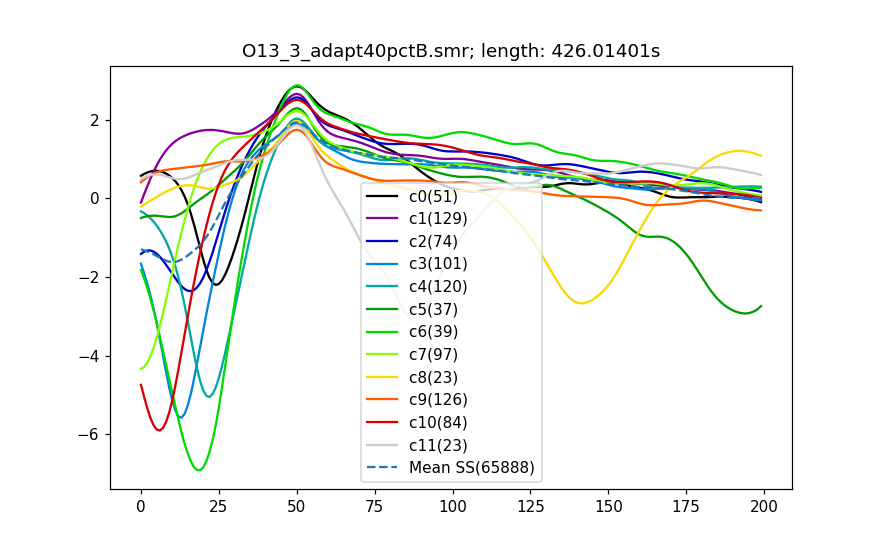

<IPython.core.display.Javascript object>


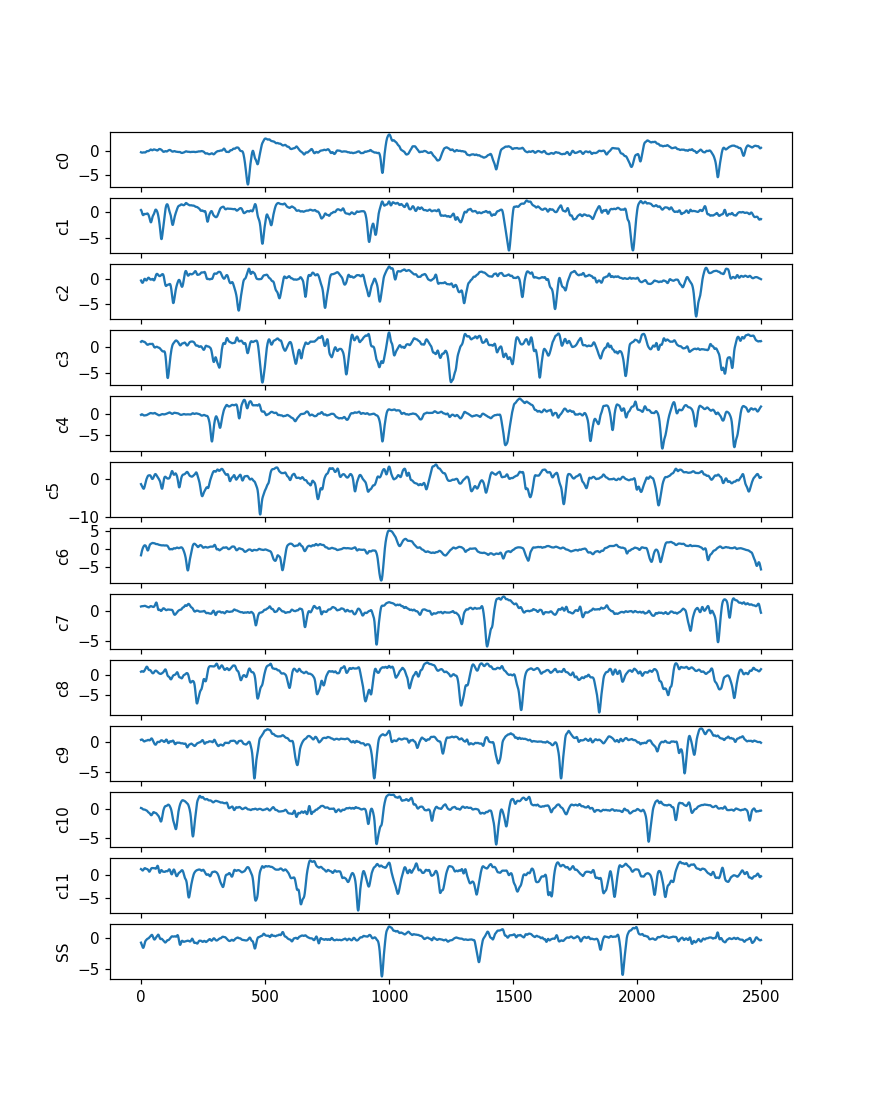

In [146]:
f_index = 1
plt.close()
filename = find_file(os.path.basename(file_names[f_index])+'.pkl', '../data/david_neurons')
print(filename)

csv_filename = filename + '.GMM.CS.csv'
cs_mean_img_filename = filename + '.4GMM.png'
trace_img_filename = filename + '.trace.4GMM.png'
csv_filename

with open(filename, 'rb') as input:
    try:
        sss = pickle.load(input, encoding='latin1')
    except TypeError:
        sss = pickle.load(input)

pre_time = 0.0005
post_time = 0.0015

pre_index = int(np.round(pre_time/sss.dt))
post_index = int(np.round(post_time/sss.dt))
aligned_cs = np.array([sss.voltage[i - pre_index : i + post_index] for i in sss.cs_indices])


import random

ss_indices = np.setdiff1d(sss.spike_indices, sss.cs_indices)
aligned_ss = np.array([sss.voltage[i - pre_index : i + post_index] for i in ss_indices[1:-2]])


mean_ss = np.mean(aligned_ss[random.sample(range(0, aligned_ss.shape[0]), sss.cs_indices.size), ], axis=0)
#         mean_ss = np.mean(aligned_ss, axis=0)
pre_time = 0.010
post_time = 0.015

pre_index = int(np.round(pre_time/sss.dt))
post_index = int(np.round(post_time/sss.dt))
aligned_cs_for_plot = np.array([sss.voltage[i - pre_index : i + post_index] for i in sss.cs_indices])
    
aligned_ss_for_plot = np.array([sss.voltage[i - pre_index : i + post_index] for i in ss_indices[50:-50]])


num_clusters = 12
gmm = GaussianMixture(num_clusters, covariance_type = 'full').fit(aligned_cs)

cluster_labels = gmm.predict(aligned_cs)

clusters = []
for cn in np.arange(num_clusters):
    clusters.append(aligned_cs[np.where(cluster_labels == cn)])

clusters_for_plot = []
for cn in np.arange(num_clusters):
    clusters_for_plot.append(aligned_cs_for_plot[np.where(cluster_labels == cn)])

colors = plt.cm.nipy_spectral(np.linspace(0,1,num_clusters))
legend_labels = []
for cn in np.arange(num_clusters):
    legend_labels.append('c{}({}) '.format(cn, clusters[cn].shape[0]))

import gc
gc.collect()
gmm_fig = plt.figure(figsize=(8,5))
# ax2 = plt.subplot(122)
for cn in np.arange(num_clusters):
    plt.plot(np.mean(clusters[cn], axis=0), color = colors[cn], label = legend_labels[cn])
plt.plot(mean_ss, '--', label = 'Mean SS({})'.format(aligned_ss.shape[0]))
# plt.show()    
plt.legend() 
plt.title('{}; length: {}s'.format(os.path.basename(file_names[f_index]),sss.voltage.shape[0]*sss.dt))
# print('Saving {} ... '.format(cs_mean_img_filename))
# plt.savefig(cs_mean_img_filename)
plt.show()


plt.figure(figsize=(8,10))
# plt.title('{}; length: {}s'.format(os.path.basename(file_names[f_index]),sss.voltage.shape[0]*sss.dt))
for cn in np.arange(num_clusters):
    plt.subplot(num_clusters+1, 1, cn+1)
    randind = random.sample(np.arange(2,clusters[cn].shape[0]-2), 1)
    plt.plot(clusters_for_plot[cn][randind[0],:])
    plt.ylabel('c{}'.format(cn))



#     ax2 = plt.subplot(512)
#     randind = random.sample(np.arange(2,clusters[1].shape[0]-2), 1)
#     plt.plot(clusters_for_plot[1][randind[0],:])
#     plt.ylabel('c1')


#     ax3 = plt.subplot(513)
#     randind = random.sample(np.arange(2,clusters[2].shape[0]-2), 1)
#     plt.plot(clusters_for_plot[2][randind[0],:])
#     plt.ylabel('c2')


#     ax4 = plt.subplot(514)
#     randind = random.sample(np.arange(2, clusters[3].shape[0]-2), 1)
#     plt.plot(clusters_for_plot[3][randind[0],:])
#     plt.ylabel('c3')

plt.subplot(num_clusters + 1, 1, num_clusters + 1)
randind = random.sample(np.arange(2, aligned_ss_for_plot.shape[0]-2), 1)
plt.plot(aligned_ss_for_plot[randind[0],:])
plt.ylabel('SS')

    # print('Saving {} ... '.format(trace_img_filename))
    # plt.savefig(trace_img_filename)
plt.show()


<IPython.core.display.Javascript object>


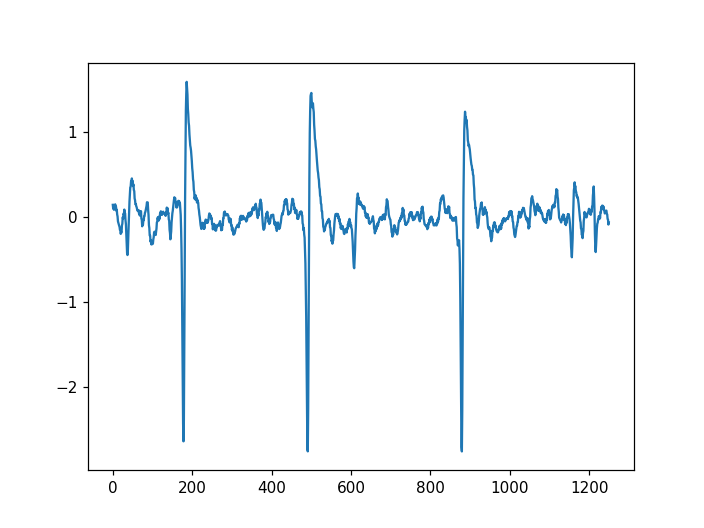

In [20]:
plt.figure()
plt.plot(aligned_ss_for_plot[randind[0],:])


<IPython.core.display.Javascript object>


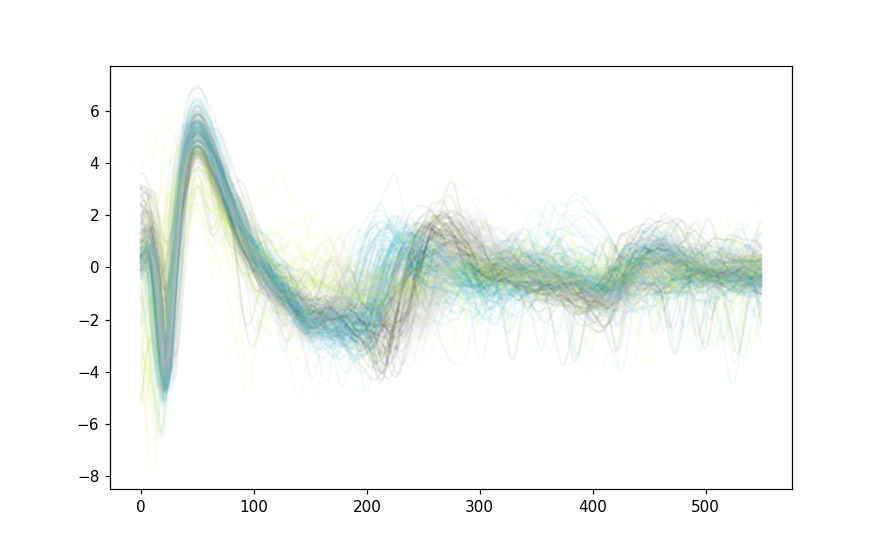

In [265]:
import gc
gc.collect()

plt.figure(figsize=(8,5))
# ax1 = plt.subplot(121)

for cn in np.arange(num_clusters):
    plt.plot(clusters[cn].T, color = colors[cn], alpha = 0.05)
plt.show()

In [123]:
print('Signal length: {} (s)'.format(sss.voltage.shape[0]*sss.dt))
for cn in np.arange(num_clusters):
    print('# of samples in c{}: {}'.format(cn, clusters[cn].shape[0]))

Signal length: 211.30048 (s)
# of samples in c0: 208
# of samples in c1: 320


In [124]:
clusters_to_pick = [0]
num_cs = 0
for ctp in clusters_to_pick:
    num_cs = num_cs + clusters[ctp].shape[0]
    
print('Number of cs in clusters {} is {}'.format(clusters_to_pick, num_cs))
    

Number of cs in clusters [0] is 208


In [125]:
isCS = np.ones((sss.cs_indices.size, 2), dtype=sss.cs_indices.dtype)*-1
isCS[:,0] = sss.cs_indices

for ctp in clusters_to_pick:
    isCS[np.where(cluster_labels == ctp), 1] = 1


In [126]:
with open(csv_filename, 'w+') as f:
    print('writing {} ... '.format(csv_filename))
    f.seek(0)
    csvwriter = csv.writer(f, delimiter = ',')
    csvwriter.writerows(isCS)


writing ../data/david_neurons/K34/K34_1Hcontrol.smr.pkl.GMM.CS.csv ... 


In [127]:
print('Saving {} ... '.format(cs_mean_img_filename))
gmm_fig.savefig(cs_mean_img_filename)


Saving ../data/david_neurons/K34/K34_1Hcontrol.smr.pkl.4GMM.png ... 


<IPython.core.display.Javascript object>


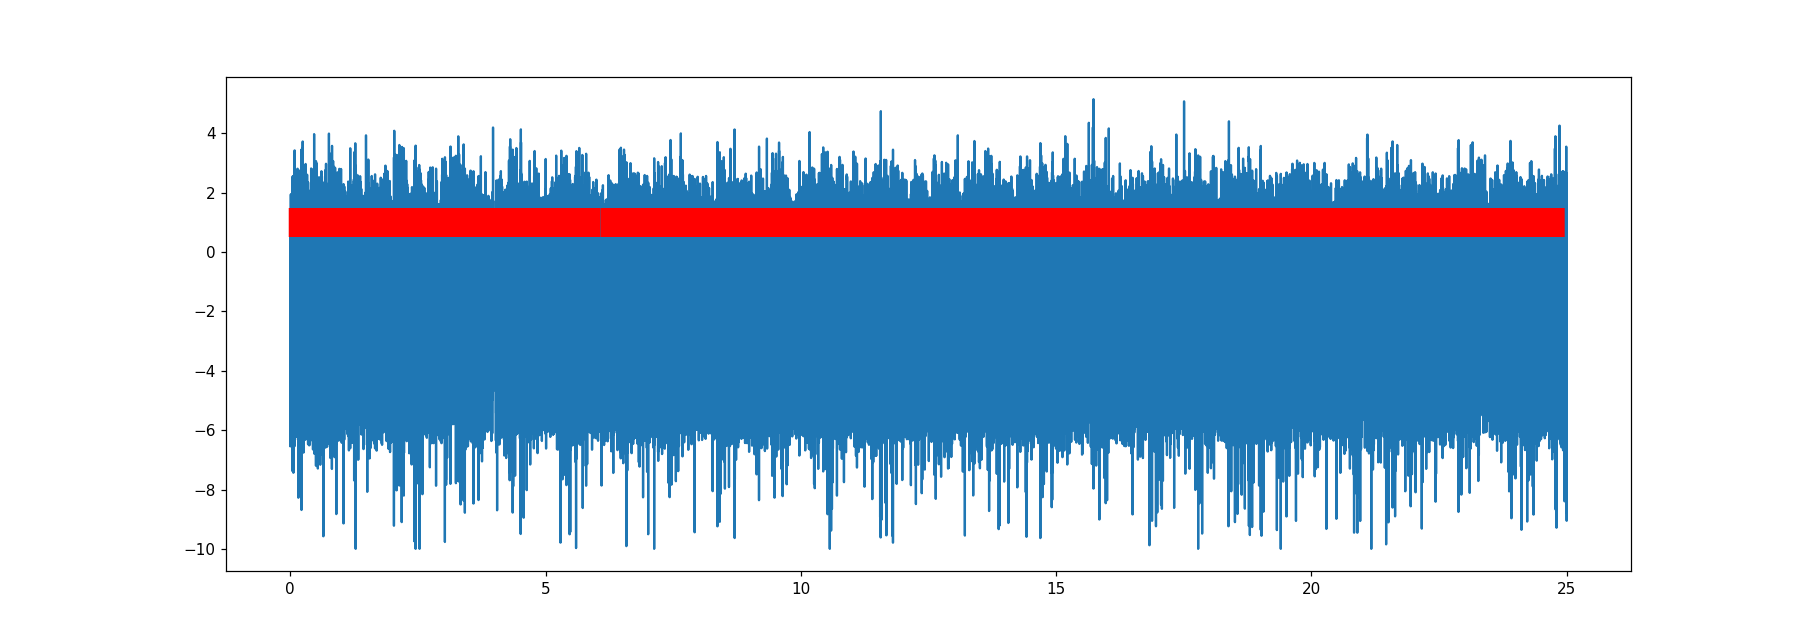

In [148]:
plt.figure()
plt.plot(np.arange(0,2500000)*sss.dt,sss.voltage[0:2500000])
plt.eventplot(sss.spike_indices[0:5000]*sss.dt, colors='r', zorder = 10)
# plt.eventplot(sss.cs_indices[0:100], colors='k', zorder = 11)